In [19]:
import os
import pickle as pk

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
import os, pathlib
# Set HF cache to project-local path (safe default for reading pickles/plots)
repo_root = pathlib.Path.cwd()
os.environ["HF_HOME"] = str(repo_root / ".cache" / "huggingface")
pathlib.Path(os.environ["HF_HOME"]).mkdir(parents=True, exist_ok=True)
print("HF_HOME=", os.environ["HF_HOME"]) 

HF_HOME= /common/home/users/m/myatmin.nay.2022/HalluRed/.cache/huggingface


In [21]:
import sys
exp = "3.10"
print("Python:", sys.version)
if not sys.version.startswith(exp):
    print(f"[WARN] Expected Python {exp}.x per environment.yml; running {sys.version.split()[0]}")


Python: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
[WARN] Expected Python 3.10.x per environment.yml; running 3.12.4


In [22]:
# load train and test scores from /data
with open('data/scores_fava_annot_llama_200samp_adapter.pkl', 'rb') as f:
# with open('data/scores_fava_annot_llama_200samp.pkl', 'rb') as f:

    scores, sample_indiv_scores, sample_labels = pk.load(f)


In [23]:
def get_roc_auc_scores(scores: np.array, labels: np.array):
    """
    Calculate ROC AUC metrics, including the AUC score, accuracy, and other key values.

    Args:
        scores (np.array): Predicted scores.
        labels (np.array): Ground Truth binary labels.

    Returns:
        tuple: A tuple containing the following:
            - arc (float): Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) curve.
            - acc (float): Maximum accuracy derived from the ROC curve.
            - low (float): True Positive Rate (TPR) at the maximum False Positive Rate (FPR) < 0.05.
            - fpr (np.ndarray): False Positive Rates at various thresholds.
            - tpr (np.ndarray): True Positive Rates at various thresholds.
            - thresh_ind (int): Index of the threshold corresponding to maximum accuracy.
            - thresh (np.ndarray): Thresholds used for calculating the ROC curve.
    """
    fpr, tpr, thresh = roc_curve(labels, scores)
    arc = auc(fpr, tpr)
    acc = np.max(1 - (fpr + (1 - tpr))/2)
    thresh_ind = np.argmax(1 - (fpr + (1 - tpr))/2)
    low = tpr[np.where(fpr<0.05)[0][-1]]
    return arc, acc, low, fpr, tpr, thresh_ind, thresh


def get_thresh_val(thresh: np.array, acc: float, scores: np.array):
    """Find approx threshold that matches avg accuracy"""
    for t in thresh:
        pred_list = np.array([ 1 if x < t else 0 for x in scores])
        if np.mean(pred_list) <= acc:
            #print(f"Accuracy: {acc:.2f} , {np.mean(pred_list):.2f}")
            return t, pred_list

def get_balanced_scores(scores: np.array, sample_labels: np.array):
    """Get balanced scores"""
    num_samp = min(sum(sample_labels), len(sample_labels)-sum(sample_labels))
    bal_sc = np.concatenate([scores[:num_samp] , scores[-num_samp:]])
    bal_labels = np.concatenate([sample_labels[:num_samp], sample_labels[-num_samp:]])
    return bal_sc, bal_labels


In [24]:
# Ensure balanced dataset!
bal_sc, bal_labels = get_balanced_scores(scores,sample_labels)
len(bal_labels), sum(bal_labels)*2

(334, 334)

In [25]:
ly_scores = -np.array(sample_indiv_scores['logit']["perplexity"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores,sample_labels))
# print(f"AUROC:{arc*100:.2f}, Acc:{acc*100:.2f}, TPR@5%FPR:{low*100:.2f}")
print(f"PPL & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

ly_scores = np.array(sample_indiv_scores['logit']["window_entropy"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores,sample_labels))
print(f"Window Entropy & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

ly_scores = np.array(sample_indiv_scores['logit']["logit_entropy"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores,sample_labels))
print(f"Logit Entropy & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

PPL & 52.62 & 56.89 & 3.59 \\
Window Entropy & 58.30 & 60.18 & 5.39 \\
Logit Entropy & 52.74 & 55.09 & 2.99 \\


Layer:1 - AUROC:0.5994, Acc:0.6108, TPR@5%FPR:0.1198
Layer:2 - AUROC:0.5721, Acc:0.5898, TPR@5%FPR:0.0479
Layer:3 - AUROC:0.6474, Acc:0.6317, TPR@5%FPR:0.1856
Layer:4 - AUROC:0.6271, Acc:0.6168, TPR@5%FPR:0.0958
Layer:5 - AUROC:0.5558, Acc:0.5898, TPR@5%FPR:0.0359
Layer:6 - AUROC:0.5518, Acc:0.5689, TPR@5%FPR:0.0778
Layer:7 - AUROC:0.5826, Acc:0.5719, TPR@5%FPR:0.0539
Layer:8 - AUROC:0.5742, Acc:0.5928, TPR@5%FPR:0.0539
Layer:9 - AUROC:0.5963, Acc:0.5988, TPR@5%FPR:0.0778
Layer:10 - AUROC:0.5449, Acc:0.5689, TPR@5%FPR:0.0838
Layer:11 - AUROC:0.5260, Acc:0.5659, TPR@5%FPR:0.0419
Layer:12 - AUROC:0.5457, Acc:0.5808, TPR@5%FPR:0.0299
Layer:13 - AUROC:0.6075, Acc:0.6228, TPR@5%FPR:0.0898
Layer:14 - AUROC:0.5213, Acc:0.5629, TPR@5%FPR:0.0180
Layer:15 - AUROC:0.5356, Acc:0.5569, TPR@5%FPR:0.0659
Layer:16 - AUROC:0.5840, Acc:0.5898, TPR@5%FPR:0.0479
Layer:17 - AUROC:0.6524, Acc:0.6527, TPR@5%FPR:0.0599
Layer:18 - AUROC:0.6782, Acc:0.6587, TPR@5%FPR:0.0898
Layer:19 - AUROC:0.6400, Acc:0.6497, 

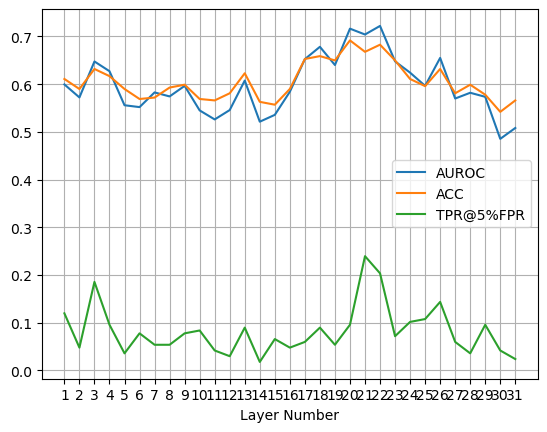

In [26]:
num_layers = len(sample_indiv_scores['attns'].keys())  # The 7B and 8B models that are being evaluated have 32 layers, so num_layers=31
arc_list, acc_list, low_list = [], [], []

samp_preds = []
thresh_vals = []

for layer_num in range(1, num_layers + 1):
    scores = -np.array(sample_indiv_scores['attns']["Attn"+str(layer_num)])
    bal_sc, bal_labels = get_balanced_scores(scores,sample_labels)
    arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(bal_sc,bal_labels)
    thresh_val, pred_list = get_thresh_val(thresh, acc, bal_sc)
    samp_preds.append(pred_list)
    thresh_vals.append(thresh_val)
    print(f"Layer:{layer_num} - AUROC:{arc:.4f}, Acc:{acc:.4f}, TPR@5%FPR:{low:.4f}")
    arc_list.append(arc)
    acc_list.append(acc)
    low_list.append(low)
    plt.plot(fpr, tpr, label = f'LY{layer_num}, AUC={arc*100:.2f}, Acc={acc*100:.2f}, TPR@5%FPR={low*100:.2f}') 

# print("Layer-wise results")
# print(arc_list)
# print(acc_list)
# print(low_list)

# # add the legend below the plot
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.savefig("plots/llama_attns_layerwise_roc_var.png", dpi=200, bbox_inches='tight')

# clear the plot
plt.clf()
plt.xticks(range(1, num_layers + 1))
plt.plot(range(1, len(arc_list) + 1), arc_list, label='AUROC')
plt.plot(range(1, len(arc_list) + 1), acc_list, label='ACC')
plt.plot(range(1, len(arc_list) + 1), low_list, label='TPR@5%FPR')
plt.xlabel('Layer Number')
plt.grid()
plt.legend()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/fava_attns_layerwise.png", dpi=200, bbox_inches='tight')
plt.show()

Hidden Layer:1 - AUROC:0.5453, Acc:0.5629, TPR@5%FPR:0.0659
Hidden Layer:2 - AUROC:0.5515, Acc:0.5659, TPR@5%FPR:0.0539
Hidden Layer:3 - AUROC:0.5464, Acc:0.5778, TPR@5%FPR:0.0539
Hidden Layer:4 - AUROC:0.5556, Acc:0.5778, TPR@5%FPR:0.0539
Hidden Layer:5 - AUROC:0.5583, Acc:0.5778, TPR@5%FPR:0.0539
Hidden Layer:6 - AUROC:0.5596, Acc:0.5778, TPR@5%FPR:0.0599
Hidden Layer:7 - AUROC:0.5564, Acc:0.5719, TPR@5%FPR:0.0599
Hidden Layer:8 - AUROC:0.5676, Acc:0.5778, TPR@5%FPR:0.0599
Hidden Layer:9 - AUROC:0.5734, Acc:0.5868, TPR@5%FPR:0.0599
Hidden Layer:10 - AUROC:0.5753, Acc:0.5838, TPR@5%FPR:0.0539
Hidden Layer:11 - AUROC:0.5788, Acc:0.5868, TPR@5%FPR:0.0958
Hidden Layer:12 - AUROC:0.5831, Acc:0.5898, TPR@5%FPR:0.0838
Hidden Layer:13 - AUROC:0.5892, Acc:0.5958, TPR@5%FPR:0.0719
Hidden Layer:14 - AUROC:0.5904, Acc:0.6018, TPR@5%FPR:0.0778
Hidden Layer:15 - AUROC:0.5943, Acc:0.6018, TPR@5%FPR:0.0778
Hidden Layer:16 - AUROC:0.5861, Acc:0.5868, TPR@5%FPR:0.0838
Hidden Layer:17 - AUROC:0.5873, A

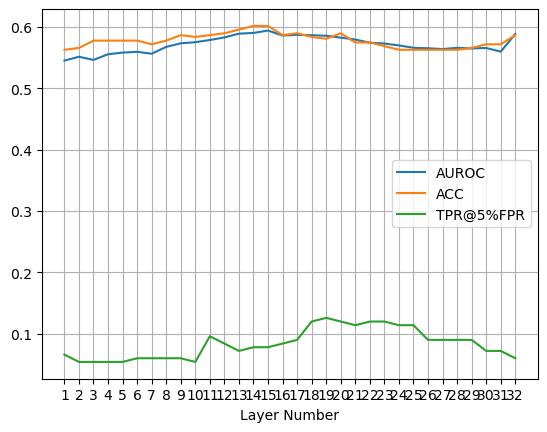

In [27]:
# Hidden layer-wise metrics
num_layers = len(sample_indiv_scores['hidden'].keys())
arc_list_h, acc_list_h, low_list_h = [], [], []

samp_preds_h = []
thresh_vals_h = []

for layer_num in range(1, num_layers + 1):
    scores = -np.array(sample_indiv_scores['hidden']["Hly" + str(layer_num)])
    bal_sc, bal_labels = get_balanced_scores(scores, sample_labels)
    arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(bal_sc, bal_labels)
    thresh_val, pred_list = get_thresh_val(thresh, acc, bal_sc)
    samp_preds_h.append(pred_list)
    thresh_vals_h.append(thresh_val)
    print(f"Hidden Layer:{layer_num} - AUROC:{arc:.4f}, Acc:{acc:.4f}, TPR@5%FPR:{low:.4f}")
    arc_list_h.append(arc)
    acc_list_h.append(acc)
    low_list_h.append(low)

# clear and plot layer-wise curves
plt.clf()
plt.xticks(range(1, num_layers + 1))
plt.plot(range(1, len(arc_list_h) + 1), arc_list_h, label='AUROC')
plt.plot(range(1, len(arc_list_h) + 1), acc_list_h, label='ACC')
plt.plot(range(1, len(arc_list_h) + 1), low_list_h, label='TPR@5%FPR')
plt.xlabel('Layer Number')
plt.grid()
plt.legend()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/fava_hidden_layerwise.png", dpi=200, bbox_inches='tight')
plt.show()
